**Date**: 05/19/2022

**Authors**: 

Xiping Gong (Email: xipinggong@umass.edu)

[Jianhan Chen](https://people.chem.umass.edu/jchenlab/) (Email: jianhanc@umass.edu)

# Import packages

In [3]:
# This will import some necessary Python packages (required to run first)
# ---------------
import numpy as np
from matplotlib import pyplot as plt

# Introduction

This module implemented the external force that can be applied into the selected particles or atoms.
Previous CPU-CHARMM program has implemented these functions [1], but they cannot be applied into the GPU calculations directly, so we have to implement them in the OpenMM/CHARMM interface by using the either custom force or plugin module. Given the OpenMM has a CustomExternalForce module, we used the customforce in this case. However, only part of functions have been implemented, for example,

```
pull off
pull force 0.1 xdir 0.0 ydir 0.0 zdir 0.0 select resid 2 .and. type CA end ! one force applied in CA atom of resid 2.
pull list
```

It is noted that the CPU-CHARMM program support the PERIod, EFIEld, TORQue modules, but these are still not supported in the OpenMM/CHARMM program.

**Reference**

[1] https://www.charmm.org/archive/charmm/documentation/by-version/c45b1/cons.html#%20External%20Forces

# Methodology

## The external force and energy

$ E_{ext} = -\sum_{i}{({\bf f}_{i} * {\bf r}_{i})}$,

where the ${\bf f}_{i}$ and ${\bf r}_{i}$ are the force and position of particle $i$.

# Implementations

## OpenMM custom forces

It is easier to use the OpenMM custom external force, please refer to the link [1].
The energy expression could be "-(x*fx + y*fy + z*fz)", and then the it could be shown as follows using a Fortran code,

```
write(formula, '(a)') '-(x*fx+y*fy+z*fz)'
```

After that, we just follows the procedures mentioned in the OpenMM documentation [1], for example, using this energy formula to create a pull force object, and then define the per-partile parameters (such as fx, fy, and fz). The next step should add all particles that will be applied on these forces, and then add this created force into the system of OpenMM.

**Reference**

[1] http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.CustomExternalForce.html

## CHARMM/OpenMM implementations

Two things should be initiallized from the CHARMM input files, the first one is to type the "pull force" commands, for example, 

```
pull off
pull force 1.0 xdir 0.0 ydir 0.0 zdir 1.0 select resid 2 .and. type CA end
pull list
```

"Pull off" will clean all pull forces,
In this step, the input data will be saved in the CPU-CHARMM module. Here, "force 1.0" means the force strength, and "xdir 0.0 ydir 0.0 zdir 1.0" means the direction of force applied, and "select resid 2 .and. type CA end" means what particles will be applied. So, in this case, one CA atom was selected, the external force (fx = force*xdir = 1.0*0.0, fy = force*ydir = 1.0*0.0, and fz = force*zdir = 1.0*1.0) can be applied. 
"pull list" will print out the information, including how many atoms were applied and their fores.

For the implementation, we first check this source code, source/charmm/miscom.F90, which will process these commands.
Initially, we set qpullforce=.true., qpullforce_import_omm=.false., where qpullforce means
the CPU calculations of pull force is on, but this CPU data has not been imported into
omm calculations, until the "omm ..." turns on. The qpullforce_omm=.falase. means the new
pullforce data is not saved into the omm pullforce object.

Then, the omm command should be typed, for example,

```
omm platform CUDA precision mixed deviceid 0
omm on

```

"omm ..." will turn on the omm calculations. This command must be after "pull force ...".
please check source code: source/openmm/omm_ctrl.F90, which will process the omm comands and also the qpullforce_omm will be turned on,

Once the qpullforce_omm=.true., the next step is to import CPU data into the GPU, then we
need to set qpullforce_import_omm=.true. by calling the setup_pullforce subroutine,
please check the source code: source/openmm/omm_bonded.F90, which call import CPU data into OpenMM.

Another thing is that we can update the imported CPU data once another "pull force ..." command coming out,

After that, the energy and dynamic calculations will use the GPU calculations.

# Correctness

To confirm the correctness of implementations, we took kid protein as a test
model, to see whether the GPU calculations can reproduce the CPU calculations. First, the
atomistic forces were calculated from the CPU and CUDA calculations. Then, the NVE imulations were also used to confirm the correctness of protein dynamics.


## CPU vs. GPU forces

The CHARMM input file is "**ener.inp**" showed as below,

```
if @?pdbid eq 0     set pdbid = kid

read  rtf card name top-idpcg-sasa.inp
read para card name hb2.0.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0

! pulling force
! --------------------------
pull off
pull force 1.0 xdir 0.0 ydir 0.0 zdir 1.0 select type CA end
!pull list

! energy and forces
! ---------------------
set natom = ?natom
! 1) CPU
energy 
! or omm platform CPU precision mixed deviceid 0
! omm on
! energy
coor force comp
print coor comp sele bynu 1:@natom end
! 2) CUDA
omm platform CUDA precision mixed deviceid 0
omm on
energy
coor force comp
print coor comp sele bynu 1:@natom end

stop
```

Then, runing the following commands, or type "**ener.sh**" shell script,

```
CHARMM=/home/ping/programs/charmm/build/omm_pullforce/charmm

$CHARMM -i ener.inp > ener.out   # charmm is an executable program
grep ' KID  ' ener.out | awk '{print $1, $5, $6, $7}' | head -181 > forces.cpu.dat # natom = 181
grep ' KID  ' ener.out | awk '{print $1, $5, $6, $7}' | tail -181 > forces.gpu.dat
```

/home/ping/pikes_home/work/pullforce/tutorial


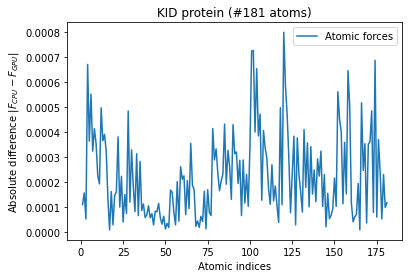

In [6]:
# CPU vs. GPU forces
# ------------------
%cd '/home/ping/pikes_home/work/pullforce/tutorial'
cpuforces = np.loadtxt('forces.cpu.dat')
gpuforces = np.loadtxt('forces.gpu.dat') # CUDA-mixed

inx = cpuforces[:,0]
diff = np.sqrt(np.sum((cpuforces[:,1:4]-gpuforces[:,1:4])**2, axis=1))
plt.plot(inx, diff,label='Atomic forces')
plt.xlabel('Atomic indices')
plt.ylabel('Absolute difference $|F_{CPU} - F_{GPU}|$')
plt.title('KID protein (#181 atoms)')
plt.legend()

**Figure 1**. The correctness of pullforce OpenMM implementations by confirming the protein forces.
The expected absolute difference should be closer to zero for all atomic indices.

## Energy conservation (NVE)

The CHARMM input file is "**nve.inp**" showed as below,

```
```

Then, runing the following commands, or type "nve.sh" shell script,

```
```

/home/ping/pikes_home/work/pullforce/tutorial


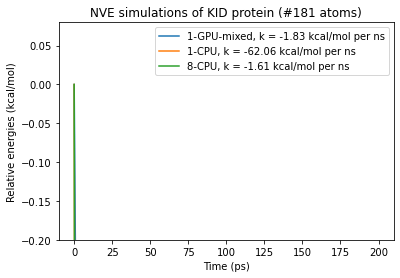

In [11]:
# NVE simulations
# ---------------
# timestep 0.002
%cd '/home/ping/pikes_home/work/pullforce/tutorial'
start = 0
fmt = '{0:.2f}'
nve1gpu = np.loadtxt('nve.1gpu.dat')
k1 = np.polyfit(nve1gpu[start:,0], nve1gpu[start:,1], 1)
nve1cpu = np.loadtxt('nve.1cpu.dat')
k2 = np.polyfit(nve1cpu[start:,0], nve1cpu[start:,1], 1)
nve8cpu = np.loadtxt('nve.8cpu.dat')
k3 = np.polyfit(nve8cpu[start:,0], nve8cpu[start:,1], 1)

plt.plot(nve1gpu[start:,0], nve1gpu[start:,1]-nve1gpu[start,1],label='1-GPU-mixed, k = '+fmt.format(k1[0]*1000)+' kcal/mol per ns')
plt.plot(nve1cpu[start:,0], nve1cpu[start:,1]-nve1cpu[start,1],label='1-CPU, k = '+fmt.format(k2[0]*1000)+' kcal/mol per ns')
plt.plot(nve8cpu[start:,0], nve8cpu[start:,1]-nve8cpu[start,1],label='8-CPU, k = '+fmt.format(k3[0]*1000)+' kcal/mol per ns')
plt.xlabel('Time (ps)')
plt.ylabel('Relative energies (kcal/mol)')
plt.title('NVE simulations of KID protein (#181 atoms)')
plt.ylim([-0.2,0.08])
plt.legend()

/home/ping/pikes_home/work/pullforce/tutorial


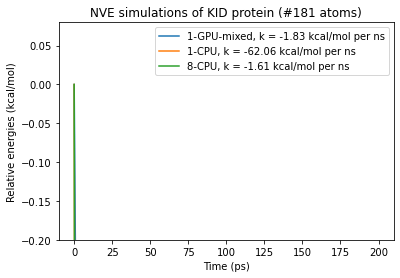

In [11]:
# NVE simulations
# ---------------
# timestep 0.002
%cd '/home/ping/pikes_home/work/pullforce/tutorial'
start = 0
fmt = '{0:.2f}'
nve1gpu = np.loadtxt('nve.1gpu.dat')
k1 = np.polyfit(nve1gpu[start:,0], nve1gpu[start:,1], 1)
nve1cpu = np.loadtxt('nve.1cpu.dat')
k2 = np.polyfit(nve1cpu[start:,0], nve1cpu[start:,1], 1)
nve8cpu = np.loadtxt('nve.8cpu.dat')
k3 = np.polyfit(nve8cpu[start:,0], nve8cpu[start:,1], 1)

plt.plot(nve1gpu[start:,0], nve1gpu[start:,1]-nve1gpu[start,1],label='1-GPU-mixed, k = '+fmt.format(k1[0]*1000)+' kcal/mol per ns')
plt.plot(nve1cpu[start:,0], nve1cpu[start:,1]-nve1cpu[start,1],label='1-CPU, k = '+fmt.format(k2[0]*1000)+' kcal/mol per ns')
plt.plot(nve8cpu[start:,0], nve8cpu[start:,1]-nve8cpu[start,1],label='8-CPU, k = '+fmt.format(k3[0]*1000)+' kcal/mol per ns')
plt.xlabel('Time (ps)')
plt.ylabel('Relative energies (kcal/mol)')
plt.title('NVE simulations of KID protein (#181 atoms)')
plt.ylim([-0.2,0.08])
plt.legend()

**Figure 3**. NVE simulations of CPU and GPU calculations. The time step was set to 2 fs for the NVE simulations and the mixed precision was used in the GPU calculations.

According to the NVE simulations, the CPU and GPU calculations are almost energy-conserved.
We also investigated the effects of computational precisions on the energy
conservation by using three options (single, mixed, and double). We observed that the mixed and
double schemes performed pretty similarly, and single scheme was a little worsen.
After comparing with the computational efficiency, we strongly suggested using the mixed precision for all GPU calculations.

/home/ping/pikes_home/work/hyres/tutorial


Text(0.5, 1.0, 'KID')

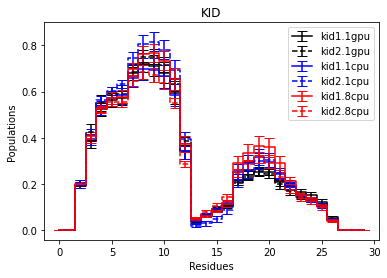

In [134]:
# Langevin dynamics (plotting)
# ----------------------------
%cd '/home/ping/pikes_home/work/hyres/tutorial'

# GPU (cons harm)
arr = np.loadtxt('kid1.1gpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='k-', label='kid1.1gpu', ds='steps-mid')
arr = np.loadtxt('kid2.1gpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='k--', label='kid2.1gpu', ds='steps-mid')

# 1-CPU
arr = np.loadtxt('kid1.1cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='b-', label='kid1.1cpu', ds='steps-mid')
arr = np.loadtxt('kid2.1cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='b--', label='kid2.1cpu', ds='steps-mid')

# 8-CPU
arr = np.loadtxt('kid1.8cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='r-', label='kid1.8cpu', ds='steps-mid')
arr = np.loadtxt('kid2.8cpu.helix')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2],
    capsize=5, fmt='r--', label='kid2.8cpu', ds='steps-mid')

plt.legend() #loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Residues')
plt.ylabel('Populations')
plt.title('KID')

# Benchmarking

## Performance


**Table 1**. The performance of CPU- and GPU-HyRes models (1 ns NVT langevin dynamics).
The CPU name is "Intel(R) Xeon(R) Silver 4110 CPU @2.10GHz" and CUDA device name is "GeForce RTX 2080".

| Devices | KID (#26) | p53-TAD (#61) | Full p53 (#290) |
| :--- | --- | --- | --- |
| CPU-1 | 1.00 | 1.00 | 1.00 |
| CPU-2 | 1.74 | 1.78 | 1.91 |
| CPU-4 | 2.69 | 3.11 | 3.51 |
| CPU-8 | 3.42 | 4.61 | 6.09 |
| CPU-16 | 3.65 | 5.67 | 8.95 |
| GPU-1 (HyRes) | 5.82 | 13.26 | 76.33 |
| GPU-1 (no-HB) | 8.54 | 22.85 | 171.52 |


Text(0.5, 1.0, 'GPU-HyRes')

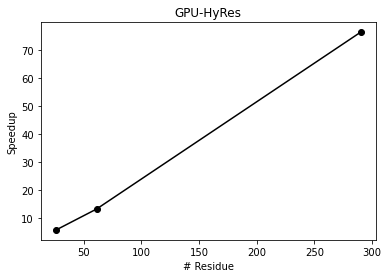

In [ ]:
table1 = Markdown('''
**Table 1**. The performance of CPU- and GPU-HyRes models (1 ns NVT langevin dynamics).
The CPU name is "Intel(R) Xeon(R) Silver 4110 CPU @2.10GHz" and CUDA device name is "GeForce RTX 2080".

| Devices | KID (#26) | p53-TAD (#61) | Full p53 (#290) |
| :--- | --- | --- | --- |
| CPU-1 | 1.00 | 1.00 | 1.00 |
| CPU-2 | 1.74 | 1.78 | 1.91 |
| CPU-4 | 2.69 | 3.11 | 3.51 |
| CPU-8 | 3.42 | 4.61 | 6.09 |
| CPU-16 | 3.65 | 5.67 | 8.95 |
| GPU-1 (HyRes) | 5.82 | 13.26 | 76.33 |
| GPU-1 (no-HB) | 8.54 | 22.85 | 171.52 |
''')
display(table1)

plt.plot([26, 61, 290], [5.82, 13.26, 76.33], 'k-o')
plt.xlabel('# Residue')
plt.ylabel('Speedup')
plt.title('GPU-HyRes')

**Figure 5**. The speedup of GPU-HyRes model with the increase of systems size (# residue).

We also tested the effect of system size on the performance of HyRes model (Table 1). It can be
seen that the GPU performance becomes faster in the larger systems, and ~76x speedup can be observed in the full length of p53 protein. 
This is because that the speedup of GPU-HyRes calculations scales with the system size.

It also showed the comparisons with the GPU calculations without HB terms, we see
that the calculation of HB term is the dominating part in the GPU-HyRes model, which almost
takes up >50 % partitions. The “nvprof” tool was also used to qualify the performance of GPU-
HyRes model. we found that two HB GPU kernels took the major contribution to the
calculation, including the “computeDonorForces” and “computeAcceptorForces”, which are
much greater than the partition of “computeNonbonded” part.

## Profiling with nvprof

```
# nvprof /home/ping/programs/charmm/build/hyres/charmm openmm=1 -i nve.inp # HyRes
# -----------------------
==16272== Profiling application: /home/ping/programs/charmm/build/hyres/charmm openmm=1 -i nve.inp
==16272== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   37.31%  7.11465s    100503  70.790us  67.776us  289.96us  computeDonorForces
                   28.99%  5.52671s    100503  54.990us  53.153us  64.961us  computeAcceptorForces
                   18.26%  3.48077s    100503  34.633us  29.472us  46.753us  computeNonbonded
                    6.72%  1.28036s    101115  12.662us  1.6000us  18.752us  computeBondedForces
                    2.68%  510.67ms    100503  5.0810us  4.1920us  12.641us  findBlockBounds
                    1.17%  223.30ms    100503  2.2210us  2.0480us  12.064us  sortShortList2
                    1.08%  206.36ms    100100  2.0610us  1.9840us  11.233us  integrateVerletPart2
                    0.95%  180.36ms    100100  1.8010us  1.7280us  11.840us  integrateVerletPart1
                    0.69%  131.23ms    100503  1.3050us  1.2480us  11.616us  sortBoxData
                    0.57%  107.75ms    101217  1.0640us     832ns  13.056us  clearTwoBuffers
                    0.53%  101.87ms    100503  1.0130us     832ns  423.62us  findBlocksWithInteractions
                    0.51%  96.648ms    102537     942ns     768ns  12.192us  [CUDA memcpy DtoD]
                    0.46%  88.106ms    105141     837ns     288ns  16.864us  [CUDA memcpy DtoH]
                    0.05%  8.6726ms      1017  8.5270us  8.3840us  10.016us  reduceEnergy
                    0.04%  7.9949ms      2279  3.5080us     608ns  19.360us  [CUDA memcpy HtoD]
                    0.01%  1.4412ms      1017  1.4170us  1.2800us  12.192us  timeShiftVelocities
      API calls:   58.33%  12.3482s    100503  122.86us  1.4450us  672.01us  cuEventSynchronize
                   28.90%  6.11777s   1108087  5.5210us  3.9490us  1.8919ms  cuLaunchKernel
                    4.67%  988.52ms    102537  9.6400us  7.5140us  3.1371ms  cuMemcpyDtoDAsync
                    2.47%  523.28ms         2  261.64ms  245.90ms  277.39ms  cuCtxCreate
                    2.42%  512.58ms    100703  5.0890us  3.9930us  451.80us  cuMemcpyDtoHAsync
                    1.51%  320.30ms      4438  72.173us  16.880us  597.66us  cuMemcpyDtoH
                    0.80%  168.81ms    100503  1.6790us  1.2890us  718.30us  cuEventRecord
                    0.55%  115.44ms      2279  50.654us  4.9520us  57.480ms  cuMemcpyHtoD
                    0.25%  52.261ms    202596     257ns     161ns  458.99us  cuCtxSetCurrent
                    0.05%  11.338ms        17  666.94us  364.53us  1.6778ms  cuModuleLoad
                    0.02%  4.0982ms         4  1.0246ms  990.33us  1.0547ms  cuMemHostAlloc
                    0.01%  2.9158ms       124  23.514us  4.3260us  193.07us  cuMemAlloc
                    0.00%  871.97us         2  435.99us  407.52us  464.46us  cuMemFreeHost
                    0.00%  768.06us         4  192.01us     424ns  766.48us  cuDriverGetVersion
                    0.00%  424.52us        54  7.8610us  4.4610us  111.72us  cuMemFree
                    0.00%  92.859us         2  46.429us  45.992us  46.867us  cuDeviceGetName
                    0.00%  39.437us        75     525ns     242ns  2.9010us  cuModuleGetFunction
                    0.00%  10.633us         4  2.6580us  1.2760us  5.8650us  cuEventCreate
                    0.00%  7.7380us         1  7.7380us  7.7380us  7.7380us  cuDeviceGetPCIBusId
                    0.00%  6.1270us        11     557ns     182ns     833ns  cuDeviceGetAttribute
                    0.00%  5.4640us         2  2.7320us  1.0170us  4.4470us  cuCtxSetLimit
                    0.00%  5.1000us         1  5.1000us  5.1000us  5.1000us  cuEventDestroy
                    0.00%  4.5500us         4  1.1370us     409ns  1.6410us  cuDeviceGetCount
                    0.00%  3.1030us         3  1.0340us     532ns  1.6610us  cuDeviceGet
                    0.00%  2.1340us         2  1.0670us  1.0650us  1.0690us  cuCtxGetLimit
                    0.00%  1.9760us         2     988ns     903ns  1.0730us  cuCtxSetCacheConfig
                    0.00%  1.9280us         2     964ns     882ns  1.0460us  cuDeviceComputeCapability
```

# Examples using the CHARMM program

Here, we provided the input files used to generate the above data.


In [126]:
%cd '/home/ping/pikes_home/work/hyres/tutorial'

print('\n # The following are the topology and parameter files and the CHARMM input files >> ')
%ls -all *.inp
print('\n # The data files generated')
%ls -all *.dat
print('\n # The calculated helicity of KID residues')
%ls -all *.helix

/home/ping/pikes_home/work/hyres/tutorial

 # The following are the topology and parameter files and the CHARMM input files >> 
-rw-r----- 1 1012 1004   981 Mar 30 14:42 ener.inp
-rw-r--r-- 1 1012 1004 35710 Mar 30 18:21 hb2.0.inp
-rw-r--r-- 1 1012 1004  2116 Mar 30 18:30 langevin.inp
-rw-r----- 1 1012 1004  1134 Mar 31 09:14 nve.inp
-rw-r----- 1 1012 1004 36567 Mar 30 14:04 param_idpcg.inp
-rw-r----- 1 1012 1004 19681 Mar 30 14:04 top_idpcg.inp
-rw-r--r-- 1 1012 1004 19726 Mar 30 18:21 top-idpcg-sasa.inp

 # The data files generated
-rw-r--r-- 1 1012 1004 53010 Mar 30 16:34 forces.cpu.dat
-rw-r--r-- 1 1012 1004 53011 Mar 30 16:34 forces.gpu.dat
-rw-r--r-- 1 1012 1004  1763 Mar 31 08:50 nve.1cpu.dat
-rw-r--r-- 1 1012 1004  1763 Mar 31 08:50 nve.1gpu.dat
-rw-r--r-- 1 1012 1004  1763 Mar 31 08:50 nve.8cpu.dat

 # The calculated helicity of KID residues
-rw-r--r-- 1 1012 1004 1016 Mar 31 10:40 kid1.1cpu.helix
-rw-r--r-- 1 1012 1004 1016 Mar 31 10:40 kid1.1gpu.helix
-rw-r--r-- 1 1012 1004 

## Energies and forces

The CHARMM input file is "**ener.inp**" showed as below,

```
if @?pdbid eq 0     set pdbid = fp53

read  rtf card name top_idpcg.inp
read para card name param_idpcg.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! energy and forces
! ---------------------
set natom = ?natom
! 1) CPU
energy 
! or omm platform CPU precision mixed deviceid 0
! omm on
! energy
coor force comp
print coor comp sele bynu 1:@natom end
! 2) CUDA
omm platform CUDA precision mixed deviceid 0
omm on
energy
coor force comp
print coor comp sele bynu 1:@natom end

stop
```

Execute the following commands in a bash environment,

```
$CHARMM -i ener.inp > ener.out   # charmm is an executable program
grep ' P53  ' ener.out | awk '{print $1, $5, $6, $7}' | head -1775 > forces.cpu.dat # natom = 1775
grep ' P53  ' ener.out | awk '{print $1, $5, $6, $7}' | tail -1775 > forces.gpu.dat

output>>
1) energies by checking out the ener.out file
==> cpu <==
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER CROSS:           CMAPs        PMF1D        PMF2D        PRIMO
ENER EXTERN:        VDWaals         ELEC       HBONds          ASP         USER
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0      2.81856      0.00000      0.39962
ENER INTERN>       48.28796    365.66936      0.00000    148.38173    120.04808
ENER CROSS>       -15.72816      0.00000      0.00000      0.00000
ENER EXTERN>     -542.03040    -20.40126   -101.40874      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------
==> gpu <==
ENER ENR:  Eval#     ENERgy      Delta-E         GRMS
ENER INTERN:          BONDs       ANGLes       UREY-b    DIHEdrals    IMPRopers
ENER CROSS:           CMAPs        PMF1D        PMF2D        PRIMO
ENER EXTERN:        VDWaals         ELEC       HBONds          ASP         USER
 ----------       ---------    ---------    ---------    ---------    ---------
ENER>        0      2.81864     -0.00008      0.39965
ENER INTERN>       48.28790    365.66973      0.00000    148.38178    120.04793
ENER CROSS>       -15.72816      0.00000      0.00000      0.00000
ENER EXTERN>     -562.43186      0.00000   -101.40870      0.00000      0.00000
 ----------       ---------    ---------    ---------    ---------    ---------

2) forces by running "head forces.*.dat"
==> forces.cpu.dat <==
1 0.02244 -0.04498 0.08463
2 0.00739 -0.00605 0.03998
3 -0.49249 0.21771 -0.26256
4 -0.00583 -0.01102 -0.01446
5 0.88928 0.24799 -0.01162
6 -0.45220 -0.28220 0.14164
7 0.89713 -0.59491 0.25717
8 -0.96810 0.21113 -0.18011
9 0.10736 0.42737 0.14898
10 0.00818 -0.07654 0.22554

==> forces.gpu.dat <==
1 0.02010 -0.04612 0.08278
2 0.00881 -0.00535 0.03896
3 -0.49517 0.21991 -0.26026
4 -0.00539 -0.01192 -0.01481
5 0.89434 0.24586 -0.00883
6 -0.45259 -0.28168 0.14091
7 0.89068 -0.59616 0.25633
8 -0.96629 0.21089 -0.17960
9 0.11157 0.42956 0.14659
10 0.00753 -0.07655 0.22543

```

## NVE simulation

The CHARMM input file is "**nve.inp**" showed as below,
```
if @?pdbid eq 0     set pdbid = fp53
if @?openmm eq 0    set openmm = 0

read  rtf card name top_idpcg.inp
read para card name param_idpcg.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! NVE simulation
!-------------------------------------------------------
set nstep = 100000
! 1) CPU
if openmm eq 0 then
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         inbfrq -1    ihbfrq -1 -
         ilbfrq 1000 nprint 1000

endif

! 2) CUDA
if openmm eq 1 then
   omm platform CUDA precision mixed deviceid 0
   omm on
   energy
   dynamics leap start timestep 0.002 nstep @nstep -
         ilbfrq 1000 nprint 1000
endif

```

Typing the following commands in a bash environment,
```
! running simulations
$CHARMM openmm=1 -i nve.inp > nve.1gpu.out
$CHARMM openmm=0 -i nve.inp > nve.1cpu.out
$mpirun -np 8 $CHARMM openmm=0 -i nve.inp > nve.8cpu.out # mpirun is an executable program

! analysis
grep 'DYNA>' nve.1gpu.out | awk '{print $3, $4}' > nve.1gpu.dat
grep 'DYNA>' nve.1cpu.out | awk '{print $3, $4}' > nve.1cpu.dat
grep 'DYNA>' nve.8cpu.out | awk '{print $3, $4}' > nve.8cpu.dat
```

## Langevin dynamic simulation

The CHARMM input file is "**langevin.inp**" showed as below,
```
if @?pdbid eq 0     set pdbid = fp53
if @?openmm eq 0    set openmm = 0
if @?label eq 0     set label = cpu
if @?deviceid eq 0  set deviceid = 0

read  rtf card name top-idpcg-sasa.inp
read para card name hb2.0.inp

read psf card name @pdbid.psf
read coor pdb name @pdbid.pdb

! DH electrostatoc potential
! --------------------------
nbond inbfrq -1
NBOND atom switch cdie vdw vswitch -
      cutnb 20.0 ctofnb 18.0 ctonnb 16.0 -
      eps 20 ionc 0.15

! Harmonic restrict
! -----------------
cons harm clear
cons harm force 1.0 sele resid 2 .and. type CA end

! Hydrogen-bonding potential
! --------------------------
hbond ihbfrq -1
HBOND NOACCEPTORS  HBNOEXCLUSIONS  ALL  -
   CUTHB 6.0 CTOFHB 5.0 CTONHB 4.0  CUTHA 100.0  CTOFHA 70.0  CTONHA 50.0

! OpenMM set up
! -------------
energy
if openmm eq 1 then
   omm platform CUDA precision mixed deviceid @deviceid
   omm on
   energy
endif

! Langevin dynamics
!-------------------------------------------------------
shake tolerance 1.0e-06 bonh param
set timestep = 0.002
energy

scalar FBETA set 0.2 select .not. hydrogen end
set nstep = 50000000 ! 50000000: 100 ns
set nprint = 50000 ! 50000: 1 print / 100 ps
set nblocks = 9 ! 9 x 100 ns

set run = 1
open writ card unit 9  name @pdbid.@label.@run.rest
open writ file unit 10 name @pdbid.@label.@run.dcd
DYNAMICS LEAP LANGEVIN start timestep @timestep nstep @nstep -
     iunread -1 iunwri 9 iuncrd 10 -
     nprint @nprint nsavc @nprint nsavv -1 isvfrq @nprint iprfrq @nstep -
     inbfrq -1 ihbfrq -1 ILBFRQ -1 -
     firstt 300.0 finalt 300.0 tbath 300.0 rbuf 0.0
! cont.
label dynloop
   set prerun = @run
   incr run by 1
   open read card unit 8  name @pdbid.@label.@prerun.rest
   open writ card unit 9  name @pdbid.@label.@run.rest
   open writ file unit 10 name @pdbid.@label.@run.dcd
   DYNAMICS LEAP LANGEVIN restart timestep @timestep nstep @nstep -
      iunread 8 iunwri 9 iuncrd 10 -
      nprint @nprint nsavc @nprint nsavv -1 isvfrq @nprint iprfrq @nstep -
      inbfrq -1 ihbfrq -1 ILBFRQ -1 -
      firstt 300.0 finalt 300.0 tbath 300.0 rbuf 0.0
if @run lt @nblocks goto dynloop

stop

```

Typing the following commands to run Langevin dynamic simulations,
```
CHARMM=/home/ping/programs/charmm/build/hyres/charmm
mpi=/home/ping/programs/openmpi/openmpi-3.0.0/build/bin/mpirun

pdbid=kid1; label=1cpu; 
$CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out &
pdbid=kid2; label=1cpu; 
$CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out &

pdbid=kid1; label=8cpu; 
$mpirun -np 8 $CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out &
pdbid=kid2; label=8cpu; 
$mpirun -np 8 $CHARMM label=$label pdbid=$pdbid openmm=0 -i langevin.inp > $pdbid.$label.out &

pdbid=kid1; label=1gpu; 
$CHARMM label=$label pdbid=$pdbid openmm=1 deviceid=0 -i langevin.inp > $pdbid.$label.out &
pdbid=kid2; label=1gpu; 
$CHARMM label=$label pdbid=$pdbid openmm=1 deviceid=1 -i langevin.inp > $pdbid.$label.out &

wait
```

# Questions

**Q1: What CHARMM version can we use to run GPU-HyRes calculations?**

It requires version > c47. If you are not sure, then using some examples to test whether it supports, or not.
Also, the HyRes model seems requires a higher version of OpenMM (>7.5.0), because there was a bug in the CustomHbondForce in previous OpenMM versions.

**Q2: How to run the GPU-HyRes calculations @pikes workstation?**

Using the following commands before running any GPU-HyRes simulations or putting them into your ~/.bashrc file.
```
# @pikes, faster node
# -------------------
# GCC
module load gcc/6.1.0
export GCCTK=/cm/local/apps/gcc/6.1.0
export CC=$GCCTK/bin/gcc
export CXX=$GCCTK/bin/g++
# OPENMM
LOCAL=/home/ping/programs/openmm/build/7.5.0
export OPENMM_DIR=$LOCAL
export OPENMM_LIB_PATH=$LOCAL/lib
export OPENMM_INCLUDE_PATH=$LOCAL/include/
export OPENMM_PLUGIN_DIR=$LOCAL/lib/plugins
# CUDA
module load cuda/10.1.243
export CUDATK=/cm/shared/apps/cuda/10.1.243
export PATH=$CUDATK/lib64:$PATH
export PATH=$CUDATK/lib64/stubs:$PATH
export PATH=$CUDATK/bin:$PATH
export OPENMM_CUDA_COMPILER=$CUDATK/bin/nvcc

CHARMM='/home/ping/programs/charmm/build/hyres/charmm'
mpirun='/home/ping/programs/openmpi/openmpi-3.0.0/build/bin/mpirun'
```

**Q3: How to quickly know I can run GPU-HyRes calculations?**

Go to the tutorial folder and run directly the ener.inp CHARMM input file.
